# Data Loading

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import shutil
from collections import defaultdict
import warnings
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
warnings.filterwarnings("ignore")
SPLIT_FACTOR = 50

In [2]:
# Folder containing the .ts files
data_dir = 'dataset'  # Change this if your folder is elsewhere

# Column names as described in the dataset documentation
column_names = [
    "Elapsed Time (sec)", "Left Stride Interval (sec)", "Right Stride Interval (sec)",
    "Left Swing Interval (sec)", "Right Swing Interval (sec)",
    "Left Swing Interval (% of stride)", "Right Swing Interval (% of stride)",
    "Left Stance Interval (sec)", "Right Stance Interval (sec)",
    "Left Stance Interval (% of stride)", "Right Stance Interval (% of stride)",
    "Double Support Interval (sec)", "Double Support Interval (% of stride)"
]

# Mapping filename prefixes to labels
label_map = {
    'als': 'ALS',
    'hunt': 'Huntington\'s',
    'park': 'Parkinson\'s',
    'control': 'Control'
}

# List to hold all DataFrames
all_dfs = []

# Process each .ts file
for filename in os.listdir(data_dir):
    if filename.endswith('.ts'):
        file_path = os.path.join(data_dir, filename)

        # Identify label based on filename prefix
        label = 'Unknown'
        for prefix, disease in label_map.items():
            if filename.lower().startswith(prefix):
                label = disease
                break

        # Read .ts file assuming whitespace-separated columns
        df = pd.read_csv(file_path, sep=r'\s+', header=None, names=column_names)

        # Add metadata
        df['Subject'] = filename.replace('.ts', '')
        df['Label'] = label

        all_dfs.append(df)

# Combine all DataFrames into one
combined_df = pd.concat(all_dfs, ignore_index=True)

# Export to CSV
combined_df.to_csv('combined_gait_data.csv', index=False)
print("Combined gait data saved to 'combined_gait_data.csv'")


Combined gait data saved to 'combined_gait_data.csv'


# EDA

In [3]:
combined_df['Subject'].value_counts()

Subject
hunt1        310
park10       288
park14       278
park2        277
control10    277
            ... 
als6         176
hunt13       167
als7         159
als4         135
als12        122
Name: count, Length: 64, dtype: int64

In [4]:
combined_df.describe()

,Elapsed Time (sec),Left Stride Interval (sec),Right Stride Interval (sec),Left Swing Interval (sec),Right Swing Interval (sec),Left Swing Interval (% of stride),Right Swing Interval (% of stride),Left Stance Interval (sec),Right Stance Interval (sec),Left Stance Interval (% of stride),Right Stance Interval (% of stride),Double Support Interval (sec),Double Support Interval (% of stride)
count,15160.000000,15160.000000,15160.000000,15160.000000,15160.000000,15160.000000,15160.000000,15160.000000,15160.000000,15160.000000,15160.000000,15160.000000,15160.000000
mean,159.964469,1.167124,1.834519,0.396971,0.395772,34.533475,33.169755,0.770154,1.438748,65.466525,66.830245,0.390781,32.113856
std,80.050060,0.690669,5.562548,0.203936,0.245472,4.394630,6.196671,0.649551,5.499786,4.394630,6.196671,0.710664,37.424367
min,21.516700,0.520000,0.506700,0.066700,0.096700,0.560000,1.010000,0.336700,0.333300,7.830000,9.140000,-1.103300,-90.680000
25%,90.629175,1.036700,1.040000,0.366700,0.350000,32.820000,31.210000,0.663300,0.676700,62.830000,63.390000,0.290000,26.947500
50%,159.518300,1.110000,1.113300,0.390000,0.383300,35.240000,34.350000,0.720000,0.736700,64.760000,65.650000,0.350000,30.955000
75%,229.080825,1.206700,1.220000,0.420000,0.420000,37.170000,36.610000,0.796700,0.820000,67.180000,68.790000,0.406700,34.852500
max,299.996700,55.150000,58.386700,23.896700,28.113300,92.170000,90.860000,54.840000,57.556700,99.440000,98.990000,56.413300,4317.350000


In [5]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15160 entries, 0 to 15159
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Elapsed Time (sec)                     15160 non-null  float64
 1   Left Stride Interval (sec)             15160 non-null  float64
 2   Right Stride Interval (sec)            15160 non-null  float64
 3   Left Swing Interval (sec)              15160 non-null  float64
 4   Right Swing Interval (sec)             15160 non-null  float64
 5   Left Swing Interval (% of stride)      15160 non-null  float64
 6   Right Swing Interval (% of stride)     15160 non-null  float64
 7   Left Stance Interval (sec)             15160 non-null  float64
 8   Right Stance Interval (sec)            15160 non-null  float64
 9   Left Stance Interval (% of stride)     15160 non-null  float64
 10  Right Stance Interval (% of stride)    15160 non-null  float64
 11  Do

In [6]:
combined_df.isna().sum()

Elapsed Time (sec)                       0
Left Stride Interval (sec)               0
Right Stride Interval (sec)              0
Left Swing Interval (sec)                0
Right Swing Interval (sec)               0
Left Swing Interval (% of stride)        0
Right Swing Interval (% of stride)       0
Left Stance Interval (sec)               0
Right Stance Interval (sec)              0
Left Stance Interval (% of stride)       0
Right Stance Interval (% of stride)      0
Double Support Interval (sec)            0
Double Support Interval (% of stride)    0
Subject                                  0
Label                                    0
dtype: int64

In [7]:
# check for duplicates
duplicates = combined_df.duplicated().sum()
duplicates

0

In [8]:
combined_df['Label'].value_counts()

Label
Huntington's    4846
Control         4076
Parkinson's     3688
ALS             2550
Name: count, dtype: int64

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15160 entries, 0 to 15159
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Elapsed Time (sec)                     15160 non-null  float64
 1   Left Stride Interval (sec)             15160 non-null  float64
 2   Right Stride Interval (sec)            15160 non-null  float64
 3   Left Swing Interval (sec)              15160 non-null  float64
 4   Right Swing Interval (sec)             15160 non-null  float64
 5   Left Swing Interval (% of stride)      15160 non-null  float64
 6   Right Swing Interval (% of stride)     15160 non-null  float64
 7   Left Stance Interval (sec)             15160 non-null  float64
 8   Right Stance Interval (sec)            15160 non-null  float64
 9   Left Stance Interval (% of stride)     15160 non-null  float64
 10  Right Stance Interval (% of stride)    15160 non-null 

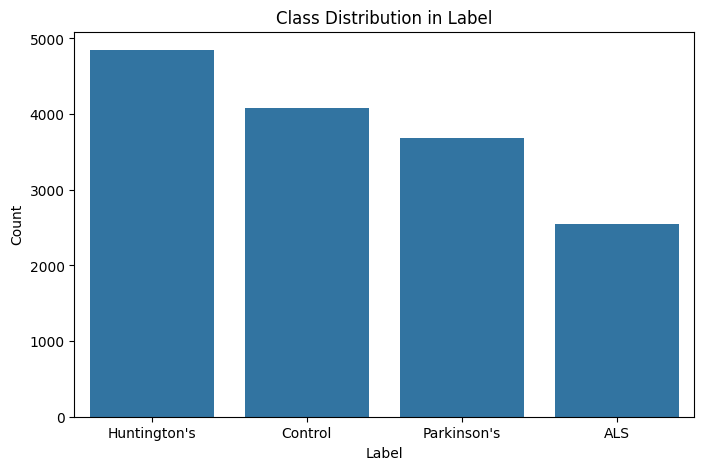

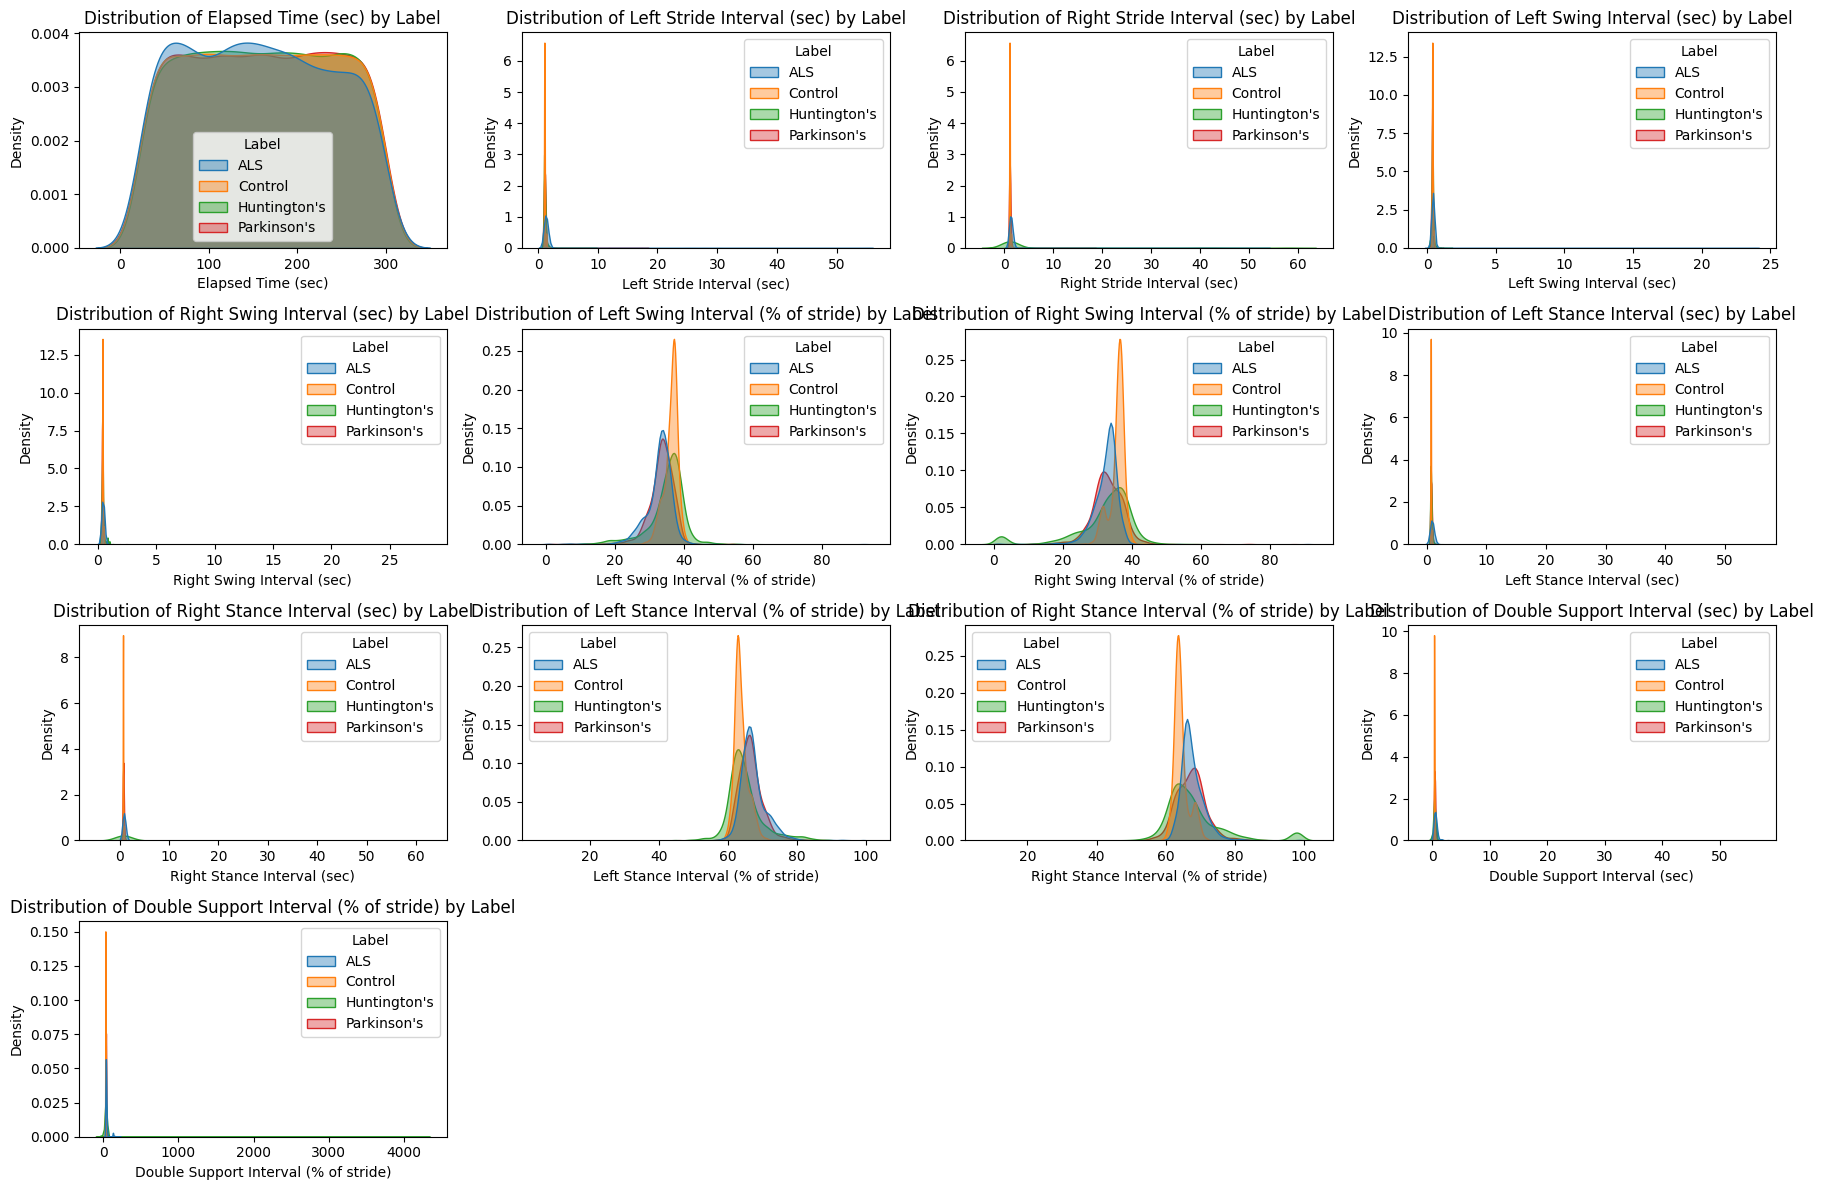

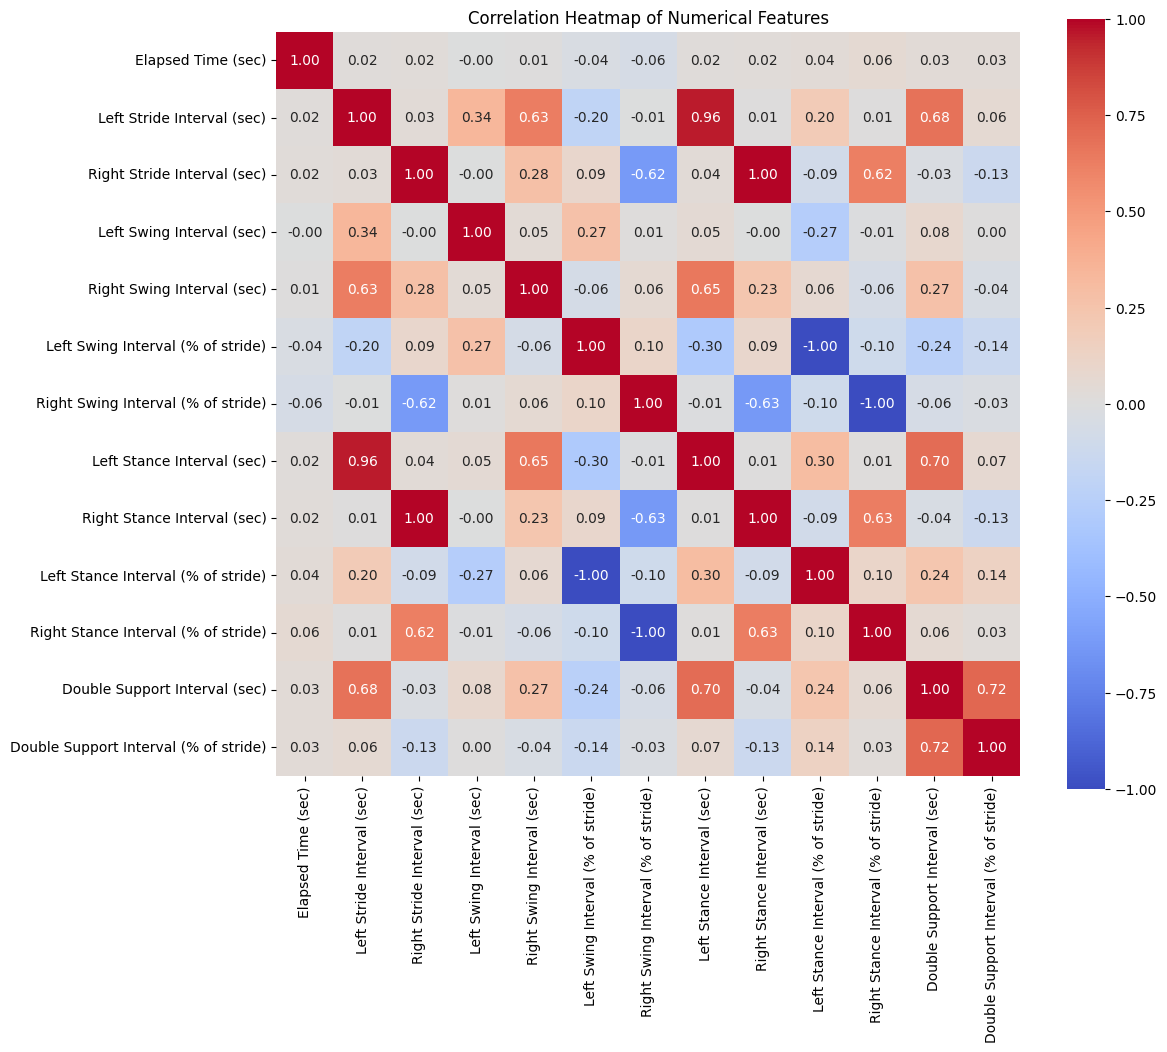

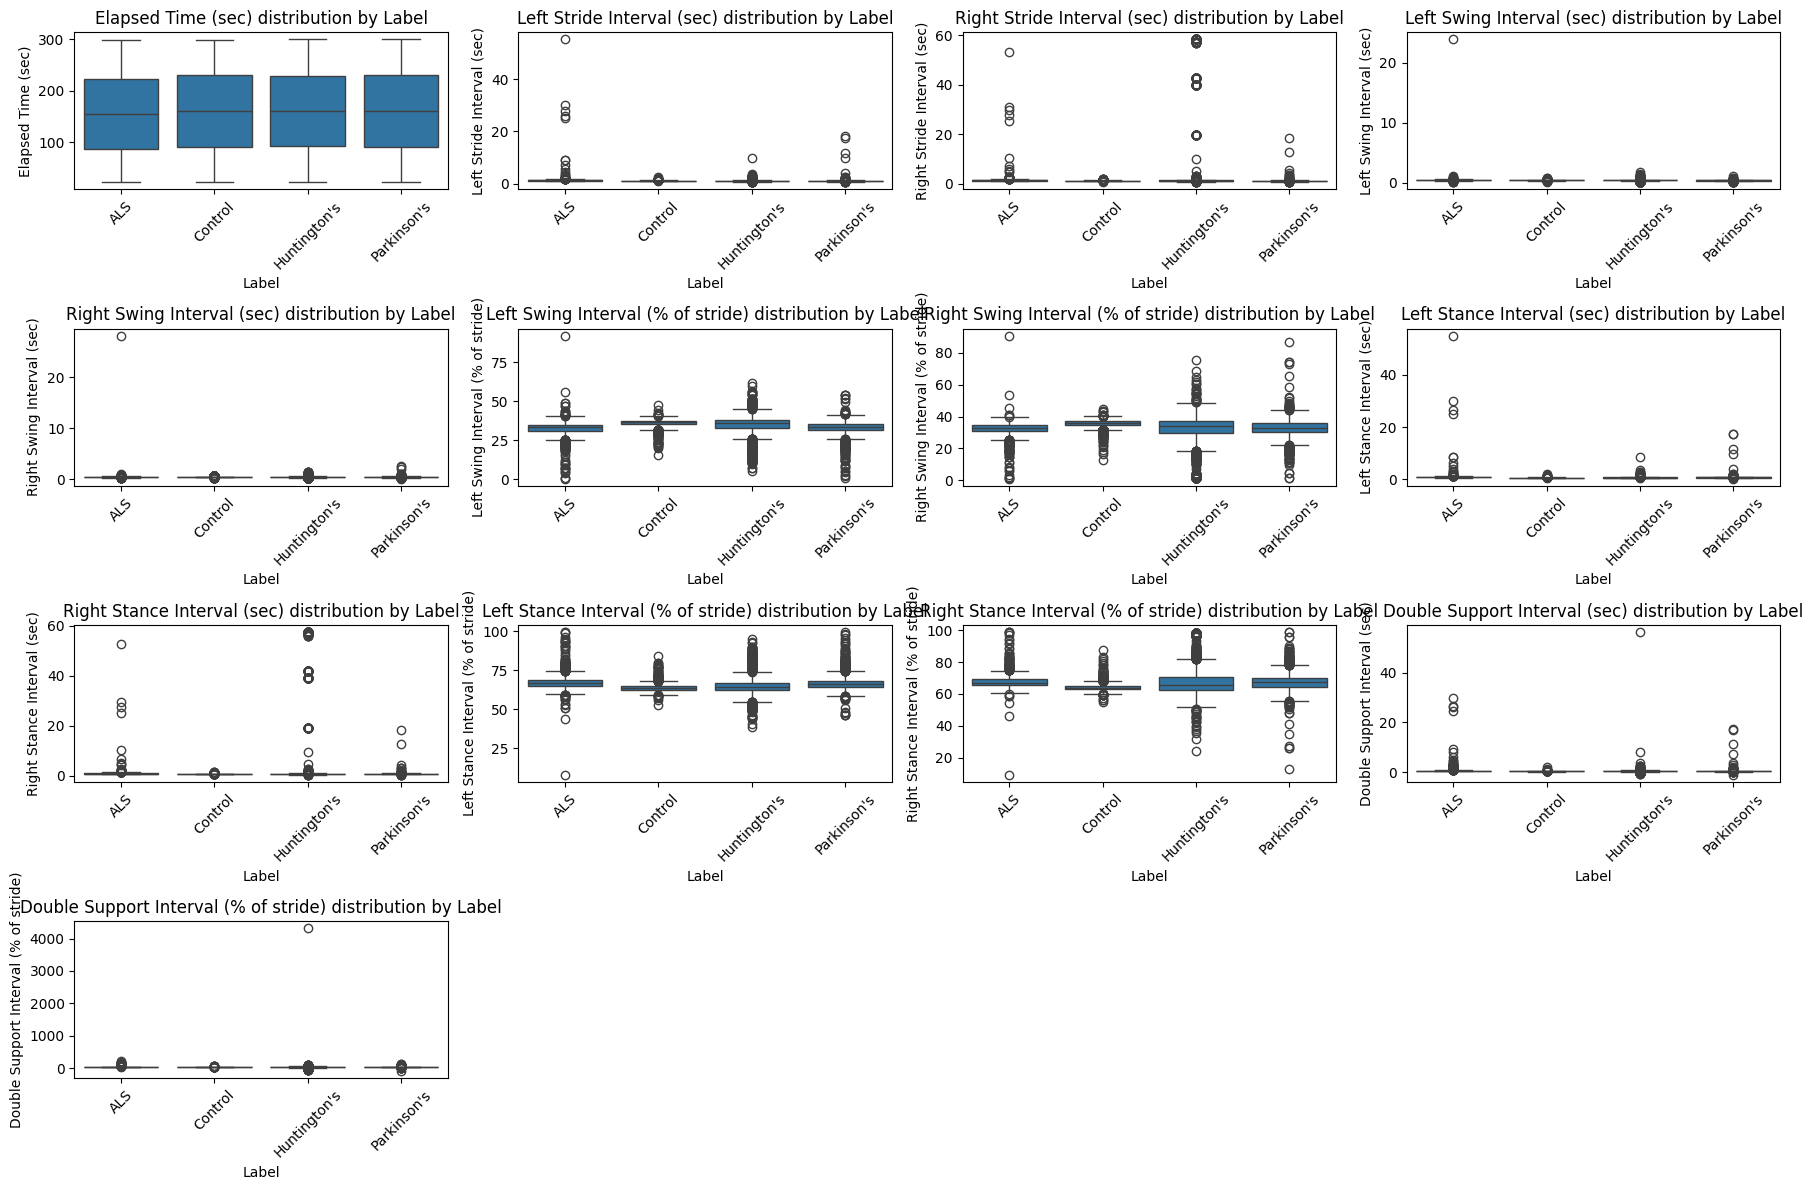

In [9]:

# Basic info and stats
print("Dataframe Info:")
print(combined_df.info())
print("\nSummary Statistics:")
print(combined_df.describe())

# Distribution of classes
plt.figure(figsize=(8,5))
sns.countplot(data=combined_df, x='Label', order=combined_df['Label'].value_counts().index)
plt.title('Class Distribution in Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Distribution plots of numerical features grouped by Label
num_features = combined_df.select_dtypes(include='float64').columns.tolist()

plt.figure(figsize=(18, 12))
for i, feature in enumerate(num_features, 1):
    plt.subplot(4, 4, i)
    sns.kdeplot(data=combined_df, x=feature, hue='Label', fill=True, common_norm=False, alpha=0.4)
    plt.title(f'Distribution of {feature} by Label')
plt.tight_layout()
plt.show()

# Correlation heatmap of numerical features
plt.figure(figsize=(12,10))
corr = combined_df[num_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# Boxplots to observe feature distribution differences by Label
plt.figure(figsize=(18, 12))
for i, feature in enumerate(num_features, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(data=combined_df, x='Label', y=feature)
    plt.title(f'{feature} distribution by Label')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
combined_df.columns

Index(['Elapsed Time (sec)', 'Left Stride Interval (sec)',
       'Right Stride Interval (sec)', 'Left Swing Interval (sec)',
       'Right Swing Interval (sec)', 'Left Swing Interval (% of stride)',
       'Right Swing Interval (% of stride)', 'Left Stance Interval (sec)',
       'Right Stance Interval (sec)', 'Left Stance Interval (% of stride)',
       'Right Stance Interval (% of stride)', 'Double Support Interval (sec)',
       'Double Support Interval (% of stride)', 'Subject', 'Label'],
      dtype='object')

In [11]:
def calculate_outlier_percentage(df, features):
    outlier_percentages = {}
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
        percentage = (len(outliers) / len(df)) * 100
        outlier_percentages[feature] = percentage
        print(f"{feature}: {percentage:.2f}% outliers")
    return outlier_percentages

num_features = combined_df.select_dtypes(include='float64').columns.tolist()
outlier_percentages = calculate_outlier_percentage(combined_df, num_features)


Elapsed Time (sec): 0.00% outliers
Left Stride Interval (sec): 7.13% outliers
Right Stride Interval (sec): 8.05% outliers
Left Swing Interval (sec): 9.11% outliers
Right Swing Interval (sec): 7.43% outliers
Left Swing Interval (% of stride): 5.22% outliers
Right Swing Interval (% of stride): 5.48% outliers
Left Stance Interval (sec): 6.99% outliers
Right Stance Interval (sec): 7.55% outliers
Left Stance Interval (% of stride): 5.22% outliers
Right Stance Interval (% of stride): 5.47% outliers
Double Support Interval (sec): 7.76% outliers
Double Support Interval (% of stride): 5.57% outliers


# Machine Learning Models

In [12]:
def extract_features_from_ts(file_path, z_score_threshold=3, metadata_df=None):
    """
    Extract statistical features from a time series file.
    
    Parameters:
        file_path (str): Path to the time series file
        
    Returns:
        dict: Dictionary of extracted features
    """
    # Read time series data
    df = pd.read_csv(file_path, sep=r'\s+', header=None, engine='python')
    features = {}
    subject_id = Path(file_path).stem
    
    # Fetch height for normalization
    height_row = metadata_df[metadata_df["subject_id"] == subject_id]
    if height_row.empty:
        raise ValueError(f"Height not found for subject {subject_id}")
    height = height_row["height"].values[0]

    # Normalize stride interval columns using height
    df[1] = df[1] / height
    df[2] = df[2] / height
    
    # Extract features from each relevant column
    for col in df.columns[1:]:
        # Skip certain columns
        if col in [3, 4, 5, 7, 8, 9, 11]:
            continue
            
        values = df[col]
        mean = values.mean()
        std = values.std()

        # Remove outliers using z-score
        if std != 0:
            z_scores = (values - mean) / std
            filtered_values = values[abs(z_scores) <= z_score_threshold]
        else:
            filtered_values = values  # avoid division by zero
        
        # Compute features on filtered values
        filtered_mean = filtered_values.mean()
        filtered_std = filtered_values.std()
        
        # Store computed features
        features[f"mean_{col}"] = filtered_mean
        # features[f"std_{col}"] = filtered_std  # Commented out in original code
        features[f"min_{col}"] = filtered_values.min()
        # features[f"max_{col}"] = filtered_values.max()  # Commented out in original code
        features[f"alo_{col}"] = filtered_std / filtered_mean if filtered_mean != 0 else 0
        
    # Add subject ID to features
    features["subject_id"] = subject_id     
    return features

In [13]:
def train_random_forest_from_ts(ts_file_paths, metadata_df):
    """
    Train a Random Forest classifier using features extracted from time series data.
    
    Parameters:
        ts_file_paths (list): List of paths to time series files
        metadata_df (pd.DataFrame): DataFrame containing metadata for subjects
        
    Returns:
        tuple: (trained model, classification report, confusion matrix, class names, features DataFrame)
    """
    
    # Constants
    Z_SCORE_THRESHOLD = 3
    CV_SPLITS = 8
    TOP_FEATURES_VIZ = 30
    TOP_FEATURES_MODEL = 15
    RANDOM_STATE = 42
    
    def compute_avg_feature_importance(X, y, n_splits):
        """
        Compute average feature importance across k cross-validation folds using Random Forest.
        
        Parameters:
            X (pd.DataFrame): Feature matrix
            y (pd.Series): Target labels
            n_splits (int): Number of cross-validation folds
            
        Returns:
            tuple: (importance DataFrame ranked by score, average importance array)
        """
        # Initialize stratified k-fold cross-validation
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
        feature_names = X.columns
        importances_accumulator = np.zeros(len(feature_names))

        # Accumulate feature importances across folds
        print(f"\n{'='*80}\nComputing average feature importance across {n_splits} folds...\n{'='*80}")
        for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
            print(f"Processing fold {fold}/{n_splits}...")
            X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
            model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
            model.fit(X_train_fold, y_train_fold)
            importances_accumulator += model.feature_importances_

        # Average across folds
        avg_importances = importances_accumulator / n_splits
        
        # Create and sort importance DataFrame
        importance_df = pd.DataFrame({
            "feature": feature_names,
            "importance": avg_importances
        }).sort_values(by="importance", ascending=False).reset_index(drop=True)

        return importance_df, avg_importances
    

    # ======= Main execution flow =======
    print(f"\n{'='*80}\nEXTRACTING FEATURES FROM TIME SERIES FILES\n{'='*80}")
    print(f"Processing {len(ts_file_paths)} time series files...")
    
    # Extract features from all provided .ts files
    feature_list = []
    for i, file_path in enumerate(ts_file_paths):
        print(f"Processing file {i+1}/{len(ts_file_paths)}: {Path(file_path).name}")
        feature_list.append(extract_features_from_ts(file_path, z_score_threshold=Z_SCORE_THRESHOLD, metadata_df=metadata_df))
    
    features_df = pd.DataFrame(feature_list)
    print(f"Features extracted successfully. Shape: {features_df.shape}")
    

    # Merge with metadata on subject_id
    print(f"\n{'='*80}\nMERGING FEATURES WITH METADATA\n{'='*80}")
    merged_df = pd.merge(features_df, metadata_df, on="subject_id", how="inner")
    merged_df = merged_df.dropna(subset=["group"])  # drop if group not available
    print(f"Merged features with metadata. Shape after merge: {merged_df.shape}")

    # Encode target labels
    label_encoder = LabelEncoder()
    merged_df["label"] = label_encoder.fit_transform(merged_df["group"])
    print(f"Target labels encoded: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

    # Prepare feature matrix (X) and target vector (y)
    X = merged_df.drop(columns=["subject_id", "group", "label", "severity"])
    X = pd.get_dummies(X, columns=["gender"], drop_first=True)
    y = merged_df["label"]
    print(f"Feature matrix shape: {X.shape}, Target vector shape: {y.shape}")
    
    # Compute and visualize correlation matrix
    print(f"\n{'='*80}\nCOMPUTING FEATURE CORRELATIONS\n{'='*80}")
    corr_matrix = X.corr()
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, fmt=".2f",
                cbar_kws={"shrink": 0.5}, linewidths=0.5)
    plt.title("Feature Correlation Heatmap")
    plt.tight_layout()
    plt.show()
    
    # Compute average feature importance
    importance_df, avg_importances = compute_avg_feature_importance(X, y, n_splits=CV_SPLITS)

    # Plot top features
    print(f"\n{'='*80}\nVISUALIZING TOP {TOP_FEATURES_VIZ} FEATURES\n{'='*80}")
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df.head(TOP_FEATURES_VIZ), x="importance", y="feature")
    plt.title(f"Top {TOP_FEATURES_VIZ} Avg Feature Importances (Random Forest)")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    # Select top features for model
    print(f"\n{'='*80}\nSELECTING TOP {TOP_FEATURES_MODEL} FEATURES FOR MODEL\n{'='*80}")
    importances = pd.Series(avg_importances, index=X.columns)
    top_features = importances.sort_values(ascending=False).head(TOP_FEATURES_MODEL).index.tolist()
    print("Selected features:")
    for i, feature in enumerate(top_features, 1):
        print(f"{i}. {feature}")

    # Reduce X to top features
    X = X[top_features]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    print(f"\nTrain set: {X_train.shape[0]} samples, Test set: {X_test.shape[0]} samples")

    # Train Random Forest
    print(f"\n{'='*80}\nTRAINING RANDOM FOREST CLASSIFIER\n{'='*80}")
    clf = RandomForestClassifier(
        n_estimators=100, 
        min_samples_leaf=2, 
        max_depth=4, 
        random_state=RANDOM_STATE
    )
    clf.fit(X_train, y_train)
    
    # # Evaluate model performance
    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    
    # Run cross-validation
    print(f"\n{'='*80}\nPERFORMING {CV_SPLITS}-FOLD CROSS-VALIDATION\n{'='*80}")
    skf = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = cross_val_score(clf, X, y, cv=skf)
    
    # Report cross-validation results
    print("Cross-Validation Scores (accuracy):")
    for i, score in enumerate(cv_scores, 1):
        print(f"  Fold {i}: {score:.4f}")
    print(f"Mean CV Accuracy:       {np.mean(cv_scores):.4f}")
    print(f"Standard Deviation CV:  {np.std(cv_scores):.4f}")
    
    # Get and visualize final model's feature importances
    print(f"\n{'='*80}\nFINAL MODEL FEATURE IMPORTANCES\n{'='*80}")
    importances = clf.feature_importances_
    feature_names = X.columns

    # Create DataFrame for plotting
    importance_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values(by="importance", ascending=False)
    
    print("Feature importances:")
    for i, (feature, importance) in enumerate(zip(importance_df['feature'], importance_df['importance']), 1):
        print(f"{i}. {feature}: {importance:.4f}")

    # Plot final model's feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x="importance", y="feature")
    plt.title(f"Feature Importances (Final Random Forest Model)")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
    
    # Evaluate on test set
    print(f"\n{'='*80}\nEVALUATION ON TEST SET\n{'='*80}")
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    matrix = confusion_matrix(y_test, y_pred)
    
    print("Classification Report:")
    print(report)
    
    print("\nConfusion Matrix:")
    print(matrix)
    
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print(f"\n{'='*80}\nRANDOM FOREST TRAINING COMPLETE\n{'='*80}")
    return clf, report, matrix, label_encoder.classes_, features_df

In [ ]:
def split_ts_files(input_folder, output_folder, split_factor):
    """
    Splits each .ts file in the input folder into equal sections based on the split factor,
    and saves all sections except the last one in the output folder.

    Parameters:
        input_folder (str): Path to the folder containing the original .ts files.
        output_folder (str): Path to the folder where the split .ts files will be saved.
        split_factor (int): Number of total segments to split the file into. Default is 3.
    """
    if split_factor < 2:
        raise ValueError("split_factor must be at least 2 to save at least one split.")

    os.makedirs(output_folder, exist_ok=True)

    for file_name in os.listdir(input_folder):
        if file_name.endswith(".ts"):
            file_path = os.path.join(input_folder, file_name)
            
            # Read the .ts file into a DataFrame
            df = pd.read_csv(file_path, sep=r'\s+', header=None, engine='python')
            total_len = len(df)
            part_len = total_len // split_factor

            for i in range(split_factor - 1):  # Exclude the last section
                start_idx = i * part_len
                end_idx = (i + 1) * part_len
                section = df.iloc[start_idx:end_idx]

                output_path = os.path.join(output_folder, f"{Path(file_name).stem}_part{i+1}.ts")
                section.to_csv(output_path, sep='\t', index=False, header=False)


dataset_path = "new_ts_files/"
subject_desc_path = "subject-description-processed.txt"

# Delete and recreate the folder
if os.path.exists(dataset_path):
    shutil.rmtree(dataset_path)
os.makedirs(dataset_path)

# Delete the processed subject description file if it exists
if os.path.exists(subject_desc_path):
    os.remove(subject_desc_path)
    
split_ts_files("dataset", "new_ts_files", split_factor=SPLIT_FACTOR)


In [ ]:
def get_all_ts_files(dataset_folder):
    """
    Recursively finds all .ts files in the given dataset folder.
    
    Parameters:
        dataset_folder (str): Path to the root dataset directory.
    
    Returns:
        List[str]: Full paths to all .ts files.
    """
    ts_files = []
    for root, _, files in os.walk(dataset_folder):
        for file in files:
            if file.endswith(".ts"):
                ts_files.append(os.path.join(root, file))
    return ts_files


In [ ]:
def get_balanced_ts_files(root_folder, max_per_class=13):
    """
    Returns a list of .ts file paths with a maximum of `max_per_class` files per class.
    """
    ts_files_by_class = defaultdict(list)

    # Load all .ts files
    for root, _, files in os.walk(root_folder):
        for file in files:
            if file.endswith(".ts"):
                path = os.path.join(root, file)
                subject_id = Path(file).stem

                # Determine class from prefix (e.g. 'park1' → 'park')
                if subject_id.startswith("park"):
                    label = "park"
                elif subject_id.startswith("hunt"):
                    label = "hunt"
                elif subject_id.startswith("als"):
                    label = "subjects"
                elif subject_id.startswith("control"):
                    label = "control"
                else:
                    continue  # skip unrecognized files

                # Add if under limit
                if len(ts_files_by_class[label]) < max_per_class:
                    ts_files_by_class[label].append(path)

    # Flatten and return the filtered list
    filtered_files = []
    for file_list in ts_files_by_class.values():
        filtered_files.extend(file_list)

    return filtered_files


In [ ]:
dataset_path = "new_ts_files/"  
# Get all .ts files from the dataset
ts_files = get_all_ts_files(dataset_path)

In [ ]:
def load_subject_metadata(file_path):
    """
    Load and clean subject metadata from subject-description.txt.

    Parameters:
        file_path (str): Path to the subject-description.txt file.

    Returns:
        pd.DataFrame: A cleaned DataFrame with subject metadata.
    """
    data = []
    with open(file_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) == 8:
            subject_id, group, age, height, weight, gender, gait_speed, severity = parts
            data.append({
                "subject_id": subject_id,
                "group": group,
                "age": None if age == "MISSING" else float(age),
                "height": None if height == "MISSING" else float(height),
                "weight": None if weight == "MISSING" else float(weight),
                "gender": gender,
                "gait_speed": None if gait_speed == "MISSING" else float(gait_speed),
                "severity": None if severity == "MISSING" else float(severity)
            })

    return pd.DataFrame(data)


In [ ]:
def process_subject_description(input_file, output_file, split_factor):
    """
    Process the subject-description.txt file to duplicate each row multiple times (based on split_factor - 1),
    modify the subject_id to reflect the part number, and exclude the last part.

    Parameters:
        input_file (str): Path to the original subject-description.txt file.
        output_file (str): Path to save the modified file.
        split_factor (int): Number of parts to split each subject into. Default is 3.
                            Only split_factor - 1 parts will be saved.
    """
    if split_factor < 2:
        raise ValueError("split_factor must be at least 2 to save at least one split.")

    with open(input_file, "r") as f:
        lines = f.readlines()

    processed_lines = []
    for line in lines[1:]:  # Skip the header
        parts = line.strip().split()
        if len(parts) == 8:
            for i in range(1, split_factor):  # Save only split_factor - 1 parts
                new_parts = parts.copy()
                new_parts[0] = f"{parts[0]}_part{i}"
                processed_lines.append(" ".join(new_parts))

    # Write the processed lines to the output file
    with open(output_file, "w") as f:
        f.write("\n".join(processed_lines) + "\n")

process_subject_description("dataset/subject-description.txt", "subject-description-processed.txt", split_factor=SPLIT_FACTOR)


In [ ]:
desc_df = load_subject_metadata("subject-description-processed.txt")

desc_df

,subject_id,group,age,height,weight,gender,gait_speed,severity
0,control1_part1,control,57.0,1.94,95.0,f,1.330,0.0
1,control1_part2,control,57.0,1.94,95.0,f,1.330,0.0
2,control1_part3,control,57.0,1.94,95.0,f,1.330,0.0
3,control1_part4,control,57.0,1.94,95.0,f,1.330,0.0
4,control1_part5,control,57.0,1.94,95.0,f,1.330,0.0
...,...,...,...,...,...,...,...,...
1211,als13_part15,subjects,66.0,1.83,NaN,m,0.832,34.0
1212,als13_part16,subjects,66.0,1.83,NaN,m,0.832,34.0
1213,als13_part17,subjects,66.0,1.83,NaN,m,0.832,34.0
1214,als13_part18,subjects,66.0,1.83,NaN,m,0.832,34.0


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def train_logistic_regression(ts_file_paths, metadata_df):
    """
    Train a Logistic Regression classifier using features extracted from time series data.
    
    Parameters:
        ts_file_paths (list): List of paths to time series files
        metadata_df (pd.DataFrame): DataFrame containing metadata for subjects
        
    Returns:
        tuple: (trained model, classification report, confusion matrix, class names, features DataFrame)
    """
    
    # Constants
    Z_SCORE_THRESHOLD = 3
    CV_SPLITS = 8
    RANDOM_STATE = 42
    
    # Get all .ts files from the dataset

    # ======= Main execution flow =======
    print(f"\n{'='*80}\nEXTRACTING FEATURES FROM TIME SERIES FILES\n{'='*80}")
    print(f"Processing {len(ts_file_paths)} time series files...")

    # Extract features from all provided .ts files
    feature_list = []
    for i, file_path in enumerate(ts_file_paths):
        print(f"Processing file {i+1}/{len(ts_file_paths)}: {Path(file_path).name}")
        feature_list.append(extract_features_from_ts(file_path, z_score_threshold=Z_SCORE_THRESHOLD, metadata_df=metadata_df))

    features_df = pd.DataFrame(feature_list)
    print(f"Features extracted successfully. Shape: {features_df.shape}")


    # Merge with metadata on subject_id
    print(f"\n{'='*80}\nMERGING FEATURES WITH METADATA\n{'='*80}")
    merged_df = pd.merge(features_df, metadata_df, on="subject_id", how="inner")
    merged_df = merged_df.dropna(subset=["group"])  # drop if group not available
    print(f"Merged features with metadata. Shape after merge: {merged_df.shape}")

    # Encode target labels
    label_encoder = LabelEncoder()
    merged_df["label"] = label_encoder.fit_transform(merged_df["group"])
    print(f"Target labels encoded: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

    # Prepare feature matrix (X) and target vector (y)
    X = merged_df.drop(columns=["subject_id", "group", "label", "severity"])
    X = pd.get_dummies(X, columns=["gender"], drop_first=True)
    y = merged_df["label"]
    # 1. Impute missing values using column mean
    imputer = SimpleImputer(strategy='mean')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    print(f"Feature matrix shape: {X.shape}, Target vector shape: {y.shape}")

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    print(f"\nTrain set: {X_train.shape[0]} samples, Test set: {X_test.shape[0]} samples")

    clf = LogisticRegression(
        max_iter=1000,           # to ensure convergence
        multi_class='multinomial',  # for multiclass support
        solver='lbfgs',          # stable solver
        random_state=RANDOM_STATE
    )
    clf.fit(X_train, y_train)

    # # Evaluate model performance
    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")

    # Run cross-validation
    print(f"\n{'='*80}\nPERFORMING {CV_SPLITS}-FOLD CROSS-VALIDATION\n{'='*80}")
    skf = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = cross_val_score(clf, X, y, cv=skf)

    # Report cross-validation results
    print("Cross-Validation Scores (accuracy):")
    for i, score in enumerate(cv_scores, 1):
        print(f"  Fold {i}: {score:.4f}")
    print(f"Mean CV Accuracy:       {np.mean(cv_scores):.4f}")
    print(f"Standard Deviation CV:  {np.std(cv_scores):.4f}")
    # Evaluate on test set
    print(f"\n{'='*80}\nEVALUATION ON TEST SET\n{'='*80}")
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    matrix = confusion_matrix(y_test, y_pred)
    
    print("Classification Report:")
    print(report)
    
    print("\nConfusion Matrix:")
    print(matrix)
    
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    return clf, report, matrix, label_encoder.classes_, features_df

    

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def train_svc(ts_file_paths, metadata_df):
    """
    Train a Logistic Regression classifier using features extracted from time series data.
    
    Parameters:
        ts_file_paths (list): List of paths to time series files
        metadata_df (pd.DataFrame): DataFrame containing metadata for subjects
        
    Returns:
        tuple: (trained model, classification report, confusion matrix, class names, features DataFrame)
    """
    
    # Constants
    Z_SCORE_THRESHOLD = 3
    CV_SPLITS = 8
    RANDOM_STATE = 42
    
    # Get all .ts files from the dataset

    # ======= Main execution flow =======
    print(f"\n{'='*80}\nEXTRACTING FEATURES FROM TIME SERIES FILES\n{'='*80}")
    print(f"Processing {len(ts_file_paths)} time series files...")

    # Extract features from all provided .ts files
    feature_list = []
    for i, file_path in enumerate(ts_file_paths):
        print(f"Processing file {i+1}/{len(ts_file_paths)}: {Path(file_path).name}")
        feature_list.append(extract_features_from_ts(file_path, z_score_threshold=Z_SCORE_THRESHOLD, metadata_df=metadata_df))

    features_df = pd.DataFrame(feature_list)
    print(f"Features extracted successfully. Shape: {features_df.shape}")


    # Merge with metadata on subject_id
    print(f"\n{'='*80}\nMERGING FEATURES WITH METADATA\n{'='*80}")
    merged_df = pd.merge(features_df, metadata_df, on="subject_id", how="inner")
    merged_df = merged_df.dropna(subset=["group"])  # drop if group not available
    print(f"Merged features with metadata. Shape after merge: {merged_df.shape}")

    # Encode target labels
    label_encoder = LabelEncoder()
    merged_df["label"] = label_encoder.fit_transform(merged_df["group"])
    print(f"Target labels encoded: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

    # Prepare feature matrix (X) and target vector (y)
    X = merged_df.drop(columns=["subject_id", "group", "label", "severity"])
    X = pd.get_dummies(X, columns=["gender"], drop_first=True)
    y = merged_df["label"]
    # 1. Impute missing values using column mean
    imputer = SimpleImputer(strategy='mean')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    print(f"Feature matrix shape: {X.shape}, Target vector shape: {y.shape}")

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    print(f"\nTrain set: {X_train.shape[0]} samples, Test set: {X_test.shape[0]} samples")

    clf = LinearSVC(
    max_iter=2000,       # increase for convergence
    C=1.0,               # regularization strength (lower = more regularization)
    random_state=42
    )
    clf.fit(X_train, y_train)

    # # Evaluate model performance
    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")

    # Run cross-validation
    print(f"\n{'='*80}\nPERFORMING {CV_SPLITS}-FOLD CROSS-VALIDATION\n{'='*80}")
    skf = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = cross_val_score(clf, X, y, cv=skf)

    # Report cross-validation results
    print("Cross-Validation Scores (accuracy):")
    for i, score in enumerate(cv_scores, 1):
        print(f"  Fold {i}: {score:.4f}")
    print(f"Mean CV Accuracy:       {np.mean(cv_scores):.4f}")
    print(f"Standard Deviation CV:  {np.std(cv_scores):.4f}")
    # Evaluate on test set
    print(f"\n{'='*80}\nEVALUATION ON TEST SET\n{'='*80}")
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    matrix = confusion_matrix(y_test, y_pred)
    
    print("Classification Report:")
    print(report)
    
    print("\nConfusion Matrix:")
    print(matrix)
    
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    return clf, report, matrix, label_encoder.classes_, features_df

    

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def train_knn(ts_file_paths, metadata_df):
    """
    Train a Logistic Regression classifier using features extracted from time series data.
    
    Parameters:
        ts_file_paths (list): List of paths to time series files
        metadata_df (pd.DataFrame): DataFrame containing metadata for subjects
        
    Returns:
        tuple: (trained model, classification report, confusion matrix, class names, features DataFrame)
    """
    
    # Constants
    Z_SCORE_THRESHOLD = 3
    CV_SPLITS = 8
    RANDOM_STATE = 42
    
    # Get all .ts files from the dataset

    # ======= Main execution flow =======
    print(f"\n{'='*80}\nEXTRACTING FEATURES FROM TIME SERIES FILES\n{'='*80}")
    print(f"Processing {len(ts_file_paths)} time series files...")

    # Extract features from all provided .ts files
    feature_list = []
    for i, file_path in enumerate(ts_file_paths):
        print(f"Processing file {i+1}/{len(ts_file_paths)}: {Path(file_path).name}")
        feature_list.append(extract_features_from_ts(file_path, z_score_threshold=Z_SCORE_THRESHOLD, metadata_df=metadata_df))

    features_df = pd.DataFrame(feature_list)
    print(f"Features extracted successfully. Shape: {features_df.shape}")


    # Merge with metadata on subject_id
    print(f"\n{'='*80}\nMERGING FEATURES WITH METADATA\n{'='*80}")
    merged_df = pd.merge(features_df, metadata_df, on="subject_id", how="inner")
    merged_df = merged_df.dropna(subset=["group"])  # drop if group not available
    print(f"Merged features with metadata. Shape after merge: {merged_df.shape}")

    # Encode target labels
    label_encoder = LabelEncoder()
    merged_df["label"] = label_encoder.fit_transform(merged_df["group"])
    print(f"Target labels encoded: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

    # Prepare feature matrix (X) and target vector (y)
    X = merged_df.drop(columns=["subject_id", "group", "label", "severity"])
    X = pd.get_dummies(X, columns=["gender"], drop_first=True)
    y = merged_df["label"]
    # 1. Impute missing values using column mean
    imputer = SimpleImputer(strategy='mean')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    print(f"Feature matrix shape: {X.shape}, Target vector shape: {y.shape}")

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    print(f"\nTrain set: {X_train.shape[0]} samples, Test set: {X_test.shape[0]} samples")

    best_k = None
    best_score = 0
    for k in [1, 3, 5, 7, 9]:
        clf = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(clf, X, y, cv=5)
        mean_score = scores.mean()
        print(f"k={k}, Mean CV Accuracy: {mean_score:.4f}")
        if mean_score > best_score:
            best_score = mean_score
            best_k = k

    print(f"\nBest k = {best_k} with Mean CV Accuracy = {best_score:.4f}")

    # Train final model with best k
    clf = KNeighborsClassifier(n_neighbors=best_k)
    clf.fit(X_train, y_train)

    # # Evaluate model performance
    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")

    # Run cross-validation
    print(f"\n{'='*80}\nPERFORMING {CV_SPLITS}-FOLD CROSS-VALIDATION\n{'='*80}")
    skf = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = cross_val_score(clf, X, y, cv=skf)

    # Report cross-validation results
    print("Cross-Validation Scores (accuracy):")
    for i, score in enumerate(cv_scores, 1):
        print(f"  Fold {i}: {score:.4f}")
    print(f"Mean CV Accuracy:       {np.mean(cv_scores):.4f}")
    print(f"Standard Deviation CV:  {np.std(cv_scores):.4f}")
    # Evaluate on test set
    print(f"\n{'='*80}\nEVALUATION ON TEST SET\n{'='*80}")
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    matrix = confusion_matrix(y_test, y_pred)
    
    print("Classification Report:")
    print(report)
    
    print("\nConfusion Matrix:")
    print(matrix)
    
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    return clf, report, matrix, label_encoder.classes_, features_df

    

## Random Forrest


EXTRACTING FEATURES FROM TIME SERIES FILES
Processing 1216 time series files...
Processing file 1/1216: als10_part1.ts
Processing file 2/1216: als10_part10.ts
Processing file 3/1216: als10_part11.ts
Processing file 4/1216: als10_part12.ts
Processing file 5/1216: als10_part13.ts
Processing file 6/1216: als10_part14.ts
Processing file 7/1216: als10_part15.ts
Processing file 8/1216: als10_part16.ts
Processing file 9/1216: als10_part17.ts
Processing file 10/1216: als10_part18.ts
Processing file 11/1216: als10_part19.ts
Processing file 12/1216: als10_part2.ts
Processing file 13/1216: als10_part3.ts
Processing file 14/1216: als10_part4.ts
Processing file 15/1216: als10_part5.ts
Processing file 16/1216: als10_part6.ts
Processing file 17/1216: als10_part7.ts
Processing file 18/1216: als10_part8.ts
Processing file 19/1216: als10_part9.ts
Processing file 20/1216: als11_part1.ts
Processing file 21/1216: als11_part10.ts
Processing file 22/1216: als11_part11.ts
Processing file 23/1216: als11_part1

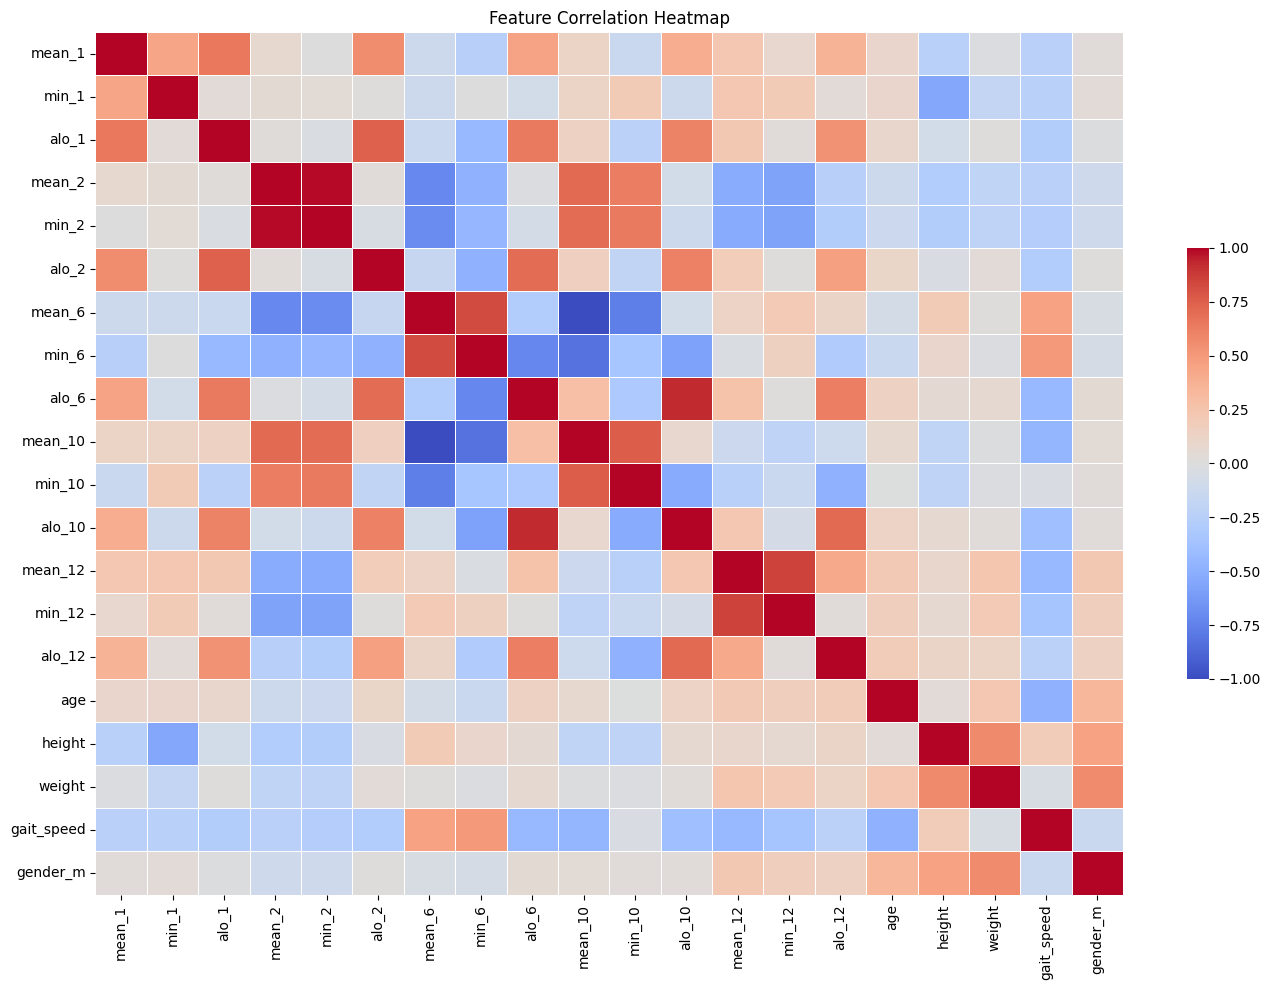


Computing average feature importance across 8 folds...
Processing fold 1/8...
Processing fold 2/8...
Processing fold 3/8...
Processing fold 4/8...
Processing fold 5/8...
Processing fold 6/8...
Processing fold 7/8...
Processing fold 8/8...

VISUALIZING TOP 30 FEATURES


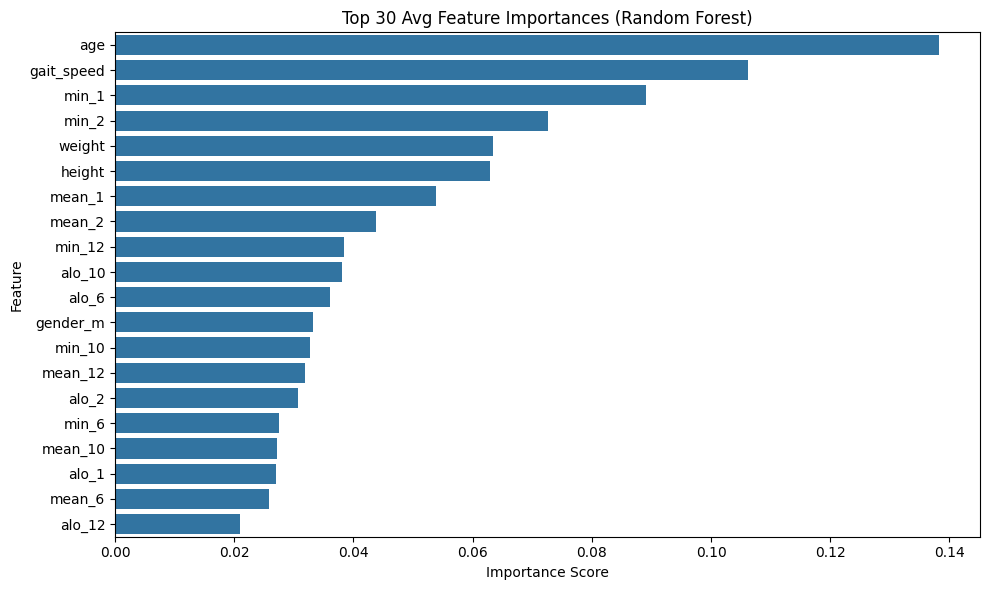


SELECTING TOP 15 FEATURES FOR MODEL
Selected features:
1. age
2. gait_speed
3. min_1
4. min_2
5. weight
6. height
7. mean_1
8. mean_2
9. min_12
10. alo_10
11. alo_6
12. gender_m
13. min_10
14. mean_12
15. alo_2

Train set: 972 samples, Test set: 244 samples

TRAINING RANDOM FOREST CLASSIFIER
Train Accuracy: 0.9280
Test Accuracy:  0.9016

PERFORMING 8-FOLD CROSS-VALIDATION
Cross-Validation Scores (accuracy):
  Fold 1: 0.9145
  Fold 2: 0.8882
  Fold 3: 0.9408
  Fold 4: 0.8947
  Fold 5: 0.9145
  Fold 6: 0.9211
  Fold 7: 0.9211
  Fold 8: 0.8882
Mean CV Accuracy:       0.9104
Standard Deviation CV:  0.0174

FINAL MODEL FEATURE IMPORTANCES
Feature importances:
1. age: 0.1423
2. gait_speed: 0.1247
3. min_1: 0.1204
4. min_2: 0.1021
5. alo_6: 0.0653
6. mean_1: 0.0629
7. alo_10: 0.0621
8. min_10: 0.0521
9. height: 0.0419
10. gender_m: 0.0415
11. weight: 0.0413
12. mean_2: 0.0409
13. alo_2: 0.0404
14. min_12: 0.0375
15. mean_12: 0.0244


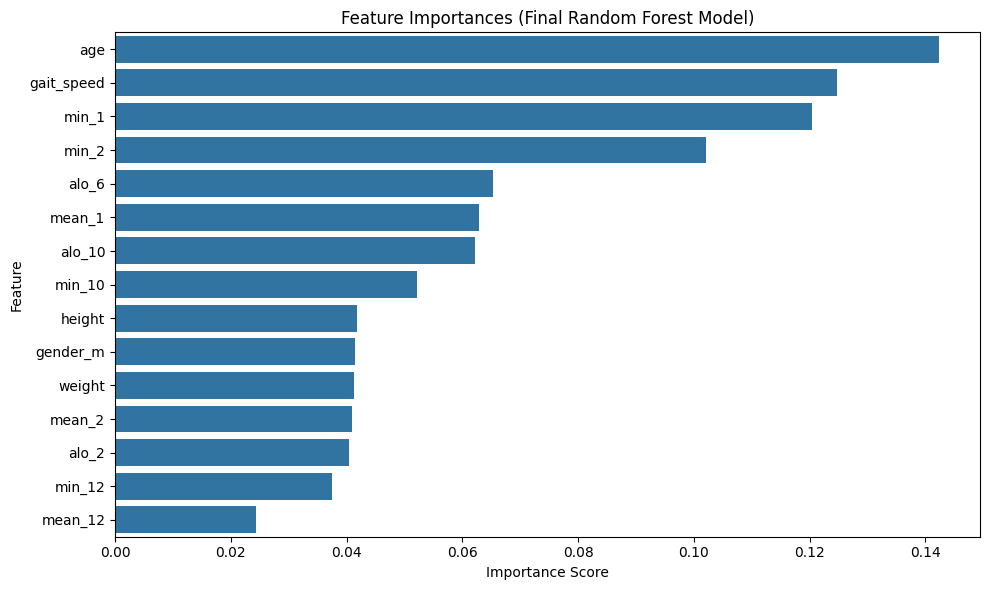


EVALUATION ON TEST SET
Classification Report:
              precision    recall  f1-score   support

     control       0.89      0.89      0.89        61
        hunt       0.86      0.89      0.88        76
        park       0.96      0.88      0.92        57
    subjects       0.92      0.96      0.94        50

    accuracy                           0.90       244
   macro avg       0.91      0.90      0.91       244
weighted avg       0.90      0.90      0.90       244


Confusion Matrix:
[[54  5  2  0]
 [ 5 68  0  3]
 [ 2  4 50  1]
 [ 0  2  0 48]]


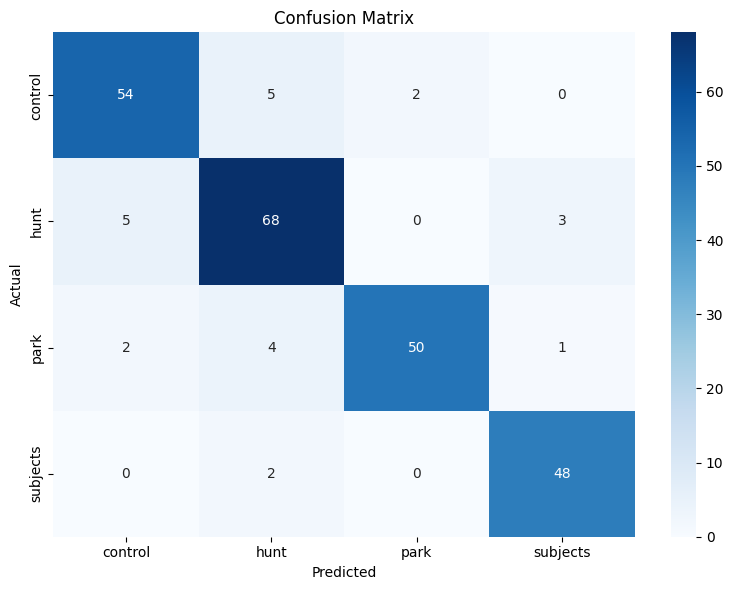


RANDOM FOREST TRAINING COMPLETE


In [ ]:
model, report, matrix, class_names, feature_df = train_random_forest_from_ts(ts_files, desc_df)

## SVM


EXTRACTING FEATURES FROM TIME SERIES FILES
Processing 1216 time series files...
Processing file 1/1216: als10_part1.ts
Processing file 2/1216: als10_part10.ts
Processing file 3/1216: als10_part11.ts
Processing file 4/1216: als10_part12.ts
Processing file 5/1216: als10_part13.ts
Processing file 6/1216: als10_part14.ts
Processing file 7/1216: als10_part15.ts
Processing file 8/1216: als10_part16.ts
Processing file 9/1216: als10_part17.ts
Processing file 10/1216: als10_part18.ts
Processing file 11/1216: als10_part19.ts
Processing file 12/1216: als10_part2.ts
Processing file 13/1216: als10_part3.ts
Processing file 14/1216: als10_part4.ts
Processing file 15/1216: als10_part5.ts
Processing file 16/1216: als10_part6.ts
Processing file 17/1216: als10_part7.ts
Processing file 18/1216: als10_part8.ts
Processing file 19/1216: als10_part9.ts
Processing file 20/1216: als11_part1.ts
Processing file 21/1216: als11_part10.ts
Processing file 22/1216: als11_part11.ts
Processing file 23/1216: als11_part1

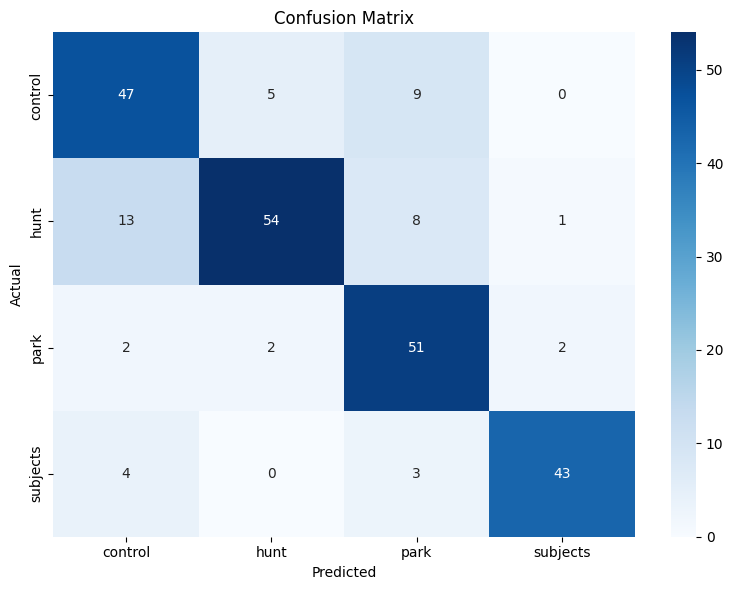

In [ ]:
model, report, matrix, class_names, feature_df = train_svc(ts_files, desc_df)

## Logistic Regression


EXTRACTING FEATURES FROM TIME SERIES FILES
Processing 1216 time series files...
Processing file 1/1216: als10_part1.ts
Processing file 2/1216: als10_part10.ts
Processing file 3/1216: als10_part11.ts
Processing file 4/1216: als10_part12.ts
Processing file 5/1216: als10_part13.ts
Processing file 6/1216: als10_part14.ts
Processing file 7/1216: als10_part15.ts
Processing file 8/1216: als10_part16.ts
Processing file 9/1216: als10_part17.ts
Processing file 10/1216: als10_part18.ts
Processing file 11/1216: als10_part19.ts
Processing file 12/1216: als10_part2.ts
Processing file 13/1216: als10_part3.ts
Processing file 14/1216: als10_part4.ts
Processing file 15/1216: als10_part5.ts
Processing file 16/1216: als10_part6.ts
Processing file 17/1216: als10_part7.ts
Processing file 18/1216: als10_part8.ts
Processing file 19/1216: als10_part9.ts
Processing file 20/1216: als11_part1.ts
Processing file 21/1216: als11_part10.ts
Processing file 22/1216: als11_part11.ts
Processing file 23/1216: als11_part1

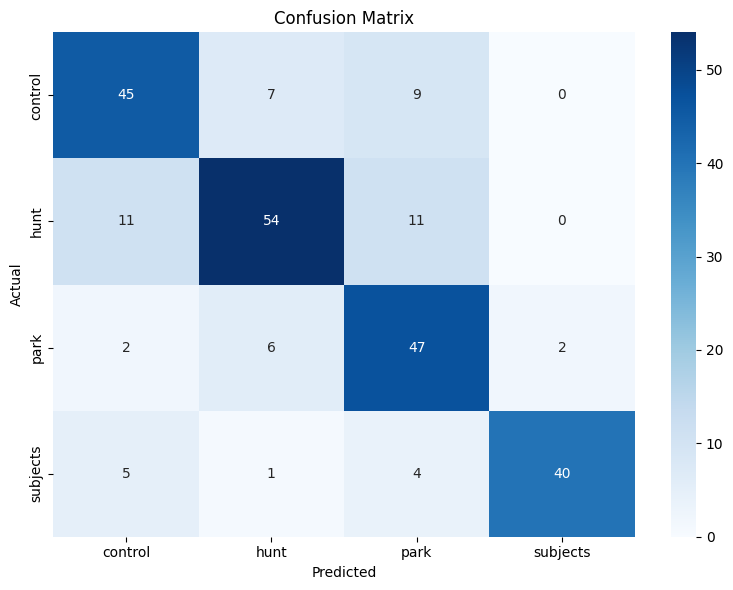

In [ ]:
model, report, matrix, class_names, feature_df = train_logistic_regression(ts_files, desc_df)